# Investigating Gencall Genotype Concordance with WGS and Imputed Genotypes

This notebook:
1. Calculates concordance rates between Gencall genotypes, imputed genotypes, and WGS.
2. Compares Gencall genotype concordance with Cluster Busterpredicted genotype concordance per snpID.
3. Correlates Gencall concordance with GenTrain Score.
4. Finds new snpIDS that GP2 should exclude from Gencall genotyping based on lower concordance rates.
5. Compares mean predicted genotype concordance between included and excluded SNPs (high vs low concordance rates) per gene.

Imports

In [85]:
import os
import sys
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg
import plotly.subplots as sp
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import ttest_ind, mannwhitneyu

# Calculate Concordance Rates Between Gencall, Imputed, and WGS Genotypes

Load CSV containing GP2 release7 SNP metrics including Gencall genotype (GT), imputed genotype (GT_imputed), and WGS (GT_wgs).
This file is produced in render_analyze_predicted_genotypes.ipynb.

In [39]:
df = pd.read_csv("data/fresh_run/release7_predictions_imputations_wgs.csv", sep=",")

/tmp/ipykernel_3569611/1555400438.py:1: DtypeWarning: Columns (21,23,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/fresh_run/release7_predictions_imputations_wgs.csv", sep=",")


Keep only samples with a valid Gencall genotype (AA, AB, BB).

In [40]:
df = df.loc[df["GT"].isin(["AA","AB","BB"])]

Create boolean columns that indicate if Gencall genotype is concordant with imputed genotype (gencall_imputed_concordant) and WGS genotype (gencall_wgs_concordant).
Also create a boolean column indicating if imputed genotype and WGS agree (wgs_imputed_concordant).

In [41]:
df['gencall_wgs_concordant'] = df["GT"] == df["GT_wgs"]
df['gencall_imputed_concordant'] = df["GT"] == df["GT_imputed"]
df['wgs_imputed_concordant'] = df["GT_wgs"] == df["GT_imputed"]

df['gencall_wgs_concordant'] = df['gencall_wgs_concordant'].mask(df["GT_wgs"].isna(), np.nan)
df['gencall_imputed_concordant'] = df['gencall_imputed_concordant'].mask(df["GT_imputed"].isna(), np.nan)
df['wgs_imputed_concordant'] = df['wgs_imputed_concordant'].mask(df["GT_wgs"].isna(), np.nan)
df['wgs_imputed_concordant'] = df['wgs_imputed_concordant'].mask(df["GT_imputed"].isna(), np.nan)

Calculate a "summary concordance" that takes imputed genotypes and WGS into account and calculate summary concordance rate per snpID.

In [42]:
def determine_concordant_summary(row):
    if row['gencall_wgs_concordant'] == True:
        return True
    if row['gencall_wgs_concordant'] == False:
        return False
    if pd.isnull(row["gencall_wgs_concordant"]) and row["gencall_imputed_concordant"] == True:
        return True
    if pd.isnull(row["gencall_wgs_concordant"]) and row["gencall_imputed_concordant"] == False:
        return False
    if pd.isnull(row["gencall_wgs_concordant"]) and pd.isnull(row["gencall_imputed_concordant"]):
        return np.NaN

df['concordant_summary'] = df.apply(determine_concordant_summary, axis=1)

Calculate concordance rate per snpID between gencall genotypes and imputed genotypes

In [43]:
gencall_imputed_concordance = df.groupby('snpID')['gencall_imputed_concordant'].mean() * 100
gencall_imputed_concordance = gencall_imputed_concordance.to_frame().reset_index()

Calculate concordance rate per snpID between gencall genotypes and WGS genotypes

In [44]:
gencall_wgs_concordance = df.groupby('snpID')['gencall_wgs_concordant'].mean() * 100
gencall_wgs_concordance = gencall_wgs_concordance.to_frame().reset_index()

Calculate concordance rate per snpID between imputed genotypes and WGS genotypes

In [45]:
wgs_imputed_concordance = df.groupby('snpID')['wgs_imputed_concordant'].mean() * 100
wgs_imputed_concordance = wgs_imputed_concordance.to_frame().reset_index()

In [46]:
summary_concordance = df.groupby('snpID')['concordant_summary'].mean() * 100
summary_concordance = summary_concordance.to_frame().reset_index()

Create summary dataframe with all four concordance rates per snpID.

In [47]:
merged = gencall_imputed_concordance.merge(gencall_wgs_concordance, on="snpID")
merged = merged.merge(summary_concordance, on="snpID")
concordance = merged.merge(wgs_imputed_concordance, on="snpID")

Add a gene and GenTrain_Score column.

In [49]:
concordance = concordance.merge(df[["snpID", "gene", "GenTrain_Score"]], how="left")
concordance = concordance.drop_duplicates()

Clean up columns.

In [50]:
concordance = concordance.rename(columns={"gencall_imputed_concordant":"gencall_imputed_concordance_rate",
                                          "gencall_wgs_concordant":"gencall_wgs_concordance_rate",
                                          "wgs_imputed_concordant":"wgs_imputed_concordance_rate",
                                          "concordant_summary": "summary_concordance_rate",
                                         })

In [51]:
numeric_cols = ["gencall_imputed_concordance_rate", "gencall_wgs_concordance_rate", "wgs_imputed_concordance_rate"]
concordance[numeric_cols] = concordance[numeric_cols].apply(pd.to_numeric, errors='coerce')

concordance[numeric_cols] = concordance[numeric_cols].round(2)

Save to a csv.

In [53]:
concordance.to_csv("data/fresh_run/gencall_genotypes_concordance_rates.csv", index=False)

# Analysis

See how many SNPs per gene have concordance rate lower than 90% between Gencall genotypes and imputed genotypes and WGS.

In [54]:
threshold = 90
wgs_snp_ids = set(concordance.loc[concordance["gencall_wgs_concordance_rate"] < threshold, "snpID"])
imp_snp_ids = set(concordance.loc[concordance["gencall_imputed_concordance_rate"] < threshold, "snpID"])
combined_snp_ids = wgs_snp_ids.union(imp_snp_ids)
snp_list = list(combined_snp_ids)

concordance_below_threshold = concordance.loc[concordance["snpID"].isin(snp_list)]
concordance_below_threshold.groupby("gene").size().astype("int")

gene
APOE      3
LRRK2    14
SNCA      6
dtype: int64

## Compare Gencall GT Concordance with Predicted GT Concordance

Load concordance rate files for Gencall genotypes and predicted genotypes.

In [56]:
concordance = pd.read_csv("data/fresh_run/gencall_genotypes_concordance_rates.csv", sep=",")
predicted = pd.read_csv("data/fresh_run/predicted_genotypes_concordance_rates.csv", sep=",")

Clean up columns.

In [66]:
snp_info = predicted.merge(concordance, on="snpID", how="inner", suffixes=("","_y"))
snp_info = snp_info.rename(columns={"concordant_wgs":"predicted_wgs_concordance_rate", 
                                    "concordant_imputed":"predicted_imputed_concordance_rate", 
                                    "concordant_summary":"predicted_summary_concordance_rate", 
                                    "summary_concordance_rate":"gencall_summary_concordance_rate", 
                                    "gene_x":"gene"})
snp_info = snp_info.drop(columns="gene_y")

Explore pearson correlation and linear regression between predicted genotype and Gencall genotype concordance rates.

In [67]:
corr_wgs = snp_info["predicted_wgs_concordance_rate"].corr(snp_info["gencall_wgs_concordance_rate"])
corr_imp = snp_info["predicted_imputed_concordance_rate"].corr(snp_info["gencall_imputed_concordance_rate"])
print(corr_wgs)
print(corr_imp)

0.1810054392372644
0.2536603952470122


In [78]:
wgs = snp_info.dropna(subset=["gencall_wgs_concordance_rate","predicted_wgs_concordance_rate"])
X = wgs[["gencall_wgs_concordance_rate"]]
Y = wgs["predicted_wgs_concordance_rate"]

model = LinearRegression()
model.fit(X, Y)

intercept = model.intercept_
slope = model.coef_[0]

r_squared = model.score(X, Y)
r_value, _ = pearsonr(wgs["gencall_wgs_concordance_rate"], wgs["predicted_wgs_concordance_rate"])

print(f'Intercept: {intercept}')
print(f'Slope: {slope}')
print(f"R-squared: {r_squared}")
print(f"R value: {r_value}")

Intercept: 20.171382393006866
Slope: 0.36679596032543577
R-squared: 0.032762969033474976
R value: 0.18100543923726448


In [80]:
imputed = snp_info.dropna(subset=["gencall_imputed_concordance_rate","predicted_imputed_concordance_rate"])
X = imputed[["gencall_imputed_concordance_rate"]]
Y = imputed["predicted_imputed_concordance_rate"]

model = LinearRegression()
model.fit(X, Y)

intercept = model.intercept_
slope = model.coef_[0]

r_squared = model.score(X, Y)
r_value, _ = pearsonr(imputed["gencall_imputed_concordance_rate"], imputed["predicted_imputed_concordance_rate"])

print(f'Intercept: {intercept}')
print(f'Slope: {slope}')
print(f"R-squared: {r_squared}")
print(f"R value: {r_value}")

Intercept: 5.306885071624009
Slope: 0.7597246399490156
R-squared: 0.06434359611687068
R value: 0.2536603952470124


## Compare Concordance with GenTrain Score

See if their is a correlation between concordance and GenTrain Score (Illumina's clustering score)

In [180]:
concordance = pd.read_csv("data/gencall_concordance_rates.csv", sep=",")
preds = pd.read_csv("data/wgs_and_imputation_predictions/release7_predictions_imputations_wgs.csv", sep=",")

/tmp/ipykernel_2038226/3577705040.py:2: DtypeWarning:

Columns (25,26,41,42,46,47,49,50,51,52,58,59,60,67,69) have mixed types. Specify dtype option on import or set low_memory=False.



In [191]:
imp_gts_corr = concordance["gencall_imputed_concordance_rate"].corr(concordance["GenTrain_Score"])
print(imp_gts_corr)
wgs_gts_corr = concordance["gencall_wgs_concordance_rate"].corr(concordance["GenTrain_Score"])
print(wgs_gts_corr)

0.4752748853589082
0.4582340997006452


## Find SNPs to Exclude Based on Concordance

GP2 tracks snpIDs that perform poorly with GenomeStudio Gencall genotyping software. This section finds if there are any untracked SNPs that should also be discluded, based on low concordance rates between Gencall genotypes and imputed genotypes and WGS.

In [94]:
concordance = pd.read_csv("data/fresh_run/gencall_genotypes_concordance_rates.csv", sep=",")
exclude = pd.read_csv("data/snps_to_exclude.txt", names=["snpID"], sep="\s+")

In [ ]:
excluded = concordance.loc[concordance["snpID"].isin(exclude["snpID"].unique().tolist())]

In [ ]:
included = concordance.loc[~concordance["snpID"].isin(exclude["snpID"].unique().tolist())]

In [93]:
threshold = 90
poor_included = included.loc[(included["gencall_imputed_concordance_rate"] < threshold) |
                            (included["gencall_wgs_concordance_rate"] < threshold)]

In [91]:
poor_included.groupby("gene").size().astype(int)

gene
APOE      3
LRRK2    14
SNCA      5
dtype: int64

In [92]:
with open("data/fresh_run/new_snps_to_exclude.txt", "w") as f:
    for snpID in poor_included["snpID"].unique():
        f.write(snpID + "\n")
f.close()

## Compare Predicted Genotype Concordance in SNPs Included and Excluded by GP2

GP2 tracks snpIDs that perform poorly with GenomeStudio Gencall genotyping software. This section determines significance of Cluster Buster difference in performance (concordance rates) between snpIDs that are excluded and included from Gencall genotyping by GP2.

Load file with Gencall, predicted, imputed, and WGS genotypes if necessary.

In [100]:
df = pd.read_csv("data/fresh_run/release7_predictions_imputations_wgs.csv", sep=",")
predictions = df.loc[df["GT"] == "NC"].copy()

Load file with concordance rates between Cluster Buster predicted genotypes and imputed genotypes and WGS.

In [108]:
pred_concordance = pd.read_csv("data/fresh_run/predicted_genotypes_concordance_rates.csv", sep=",")

Load list of GP2 excluded SNPs a

In [109]:
exclude = pd.read_csv("data/snps_to_exclude.txt", names=["snpID"], sep="\s+")
new_exclude = pd.read_csv("data/fresh_run/new_snps_to_exclude.txt", names=["snpID"], sep="\s+")
exclude = pd.concat([exclude, new_exclude])

In [110]:
excluded = predictions.loc[predictions["snpID"].isin(exclude["snpID"].unique().tolist())]
included = predictions.loc[~predictions["snpID"].isin(excluded["snpID"].unique().tolist())]

In [111]:
excluded_snps = exclude["snpID"].unique().tolist()
pred_concordance['excluded'] = pred_concordance['snpID'].apply(lambda x: 1 if x in excluded_snps else 0)

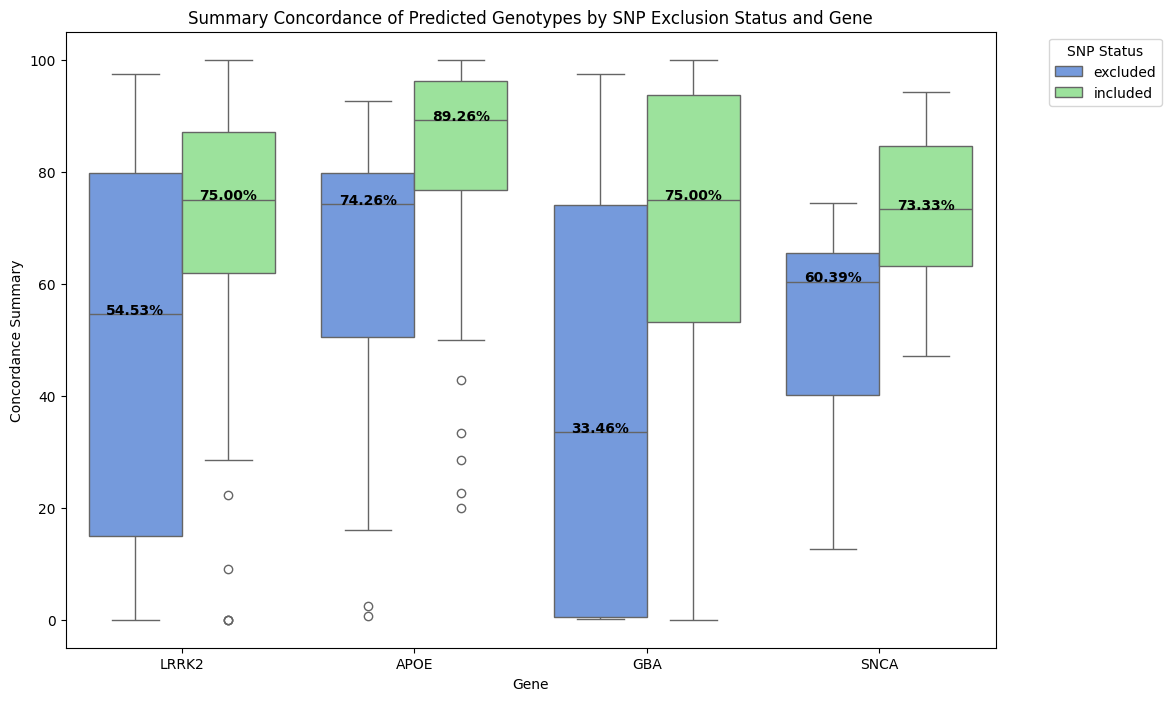

In [114]:
plt.figure(figsize=(12, 8))
palette = {1: 'cornflowerblue', 0: 'lightgreen'}
sns.boxplot(x='gene', y='concordant_summary', hue='excluded', hue_order=[1,0], palette=palette, data=pred_concordance)

plt.title('Summary Concordance of Predicted Genotypes by SNP Exclusion Status and Gene')
plt.xlabel('Gene')
plt.ylabel('Concordance Summary')

medians = pred_concordance.groupby(['gene', 'excluded'])['concordant_summary'].median().reset_index()
for i in range(medians.shape[0]):
    gene = medians['gene'].iloc[i]
    excluded = medians['excluded'].iloc[i]
    median_value = medians['concordant_summary'].iloc[i]
    x_pos = list(concordance['gene'].unique()).index(gene) + (-0.2 if excluded == 1 else 0.2)
    plt.text(x_pos, median_value + 0.7, f'{median_value:.2f}%', ha='center', va='center', fontweight='bold', color='black')


handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['excluded', 'included']
plt.legend(handles, new_labels, title='SNP Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('figures/preprint/new_boxplot_predicted_excluded_vs_included_snps.pdf', bbox_inches='tight')
plt.show()


### MannWhitneyU

In [116]:
result = []

for gene, group in pred_concordance.groupby('gene'):
    excluded_0 = group[group['excluded'] == 0]['concordant_summary']
    excluded_1 = group[group['excluded'] == 1]['concordant_summary']
    
    if len(excluded_0) > 1 and len(excluded_1) > 1:
        t_stat, p_value = mannwhitneyu(excluded_0, excluded_1)
        
        result.append({
            'gene': gene,
            'p_value': p_value,
            'excluded_0_mean': excluded_0.mean(),
            'excluded_1_mean': excluded_1.mean(),
            't_stat': t_stat
        })

result_df = pd.DataFrame(result)
result_df

,gene,p_value,excluded_0_mean,excluded_1_mean,t_stat
0,APOE,0.000582,83.400130,59.607926,927.0
1,GBA,0.192531,71.422479,41.118595,247.0
2,LRRK2,0.001821,72.825863,49.509807,4319.0
3,SNCA,0.002249,73.278976,52.415768,303.0
